# Data Analysis Project: COVID-19 Risk Evaluation
* Author: Marco Andronaco
* Subject: Statistical Laboratory
* Teacher: Alessandro Ortis - University of Catania

## Step 0: libraries and constants
First of all, let's install the required libraries for this analysis.

The `require()` function returns `FALSE` if the requested library is not installed, so we can install it only when necessary.

In [1]:
if (!require("corrplot")) install.packages("corrplot")
if (!require("klaR")) install.packages("klaR")

library("corrplot") # corrplot()
library("klaR") # kmodes()
library("cluster") # clusplot()

Caricamento del pacchetto richiesto: corrplot

corrplot 0.92 loaded

Caricamento del pacchetto richiesto: klaR

Caricamento del pacchetto richiesto: MASS



To get a consistent feel for my analysis, I decided to use the [Open Color 1.9.1](https://yeun.github.io/open-color/) palette.

In [2]:
col.gray = "#adb5bd"
col.red = "#ff6b6b"
col.pink = "#f06595"
col.grape = "#cc5de8"
col.violet = "#845ef7"
col.indigo = "#5c7cfa"
col.blue = "#339af0"
col.cyan = "#22b8cf"
col.teal = "#20c997"
col.green = "#51cf66"
col.lime = "#94d82d"
col.yellow = "#fcc419"
col.orange = "#ff922b"

## Step 1: Data Pre-Processing
The dataset comes from [Kaggle](https://www.kaggle.com/datasets/meirnizri/covid19-dataset). Here's the provided description:

>Coronavirus disease (COVID-19) is an infectious disease caused by a newly discovered coronavirus. Most people infected with COVID-19 virus will experience mild to moderate respiratory illness and recover without requiring special treatment. Older people, and those with underlying medical problems like cardiovascular disease, diabetes, chronic respiratory disease, and cancer are more likely to develop serious illness.
>During the entire course of the pandemic, one of the main problems that healthcare providers have faced is the shortage of medical resources and a proper plan to efficiently distribute them. In these tough times, being able to predict what kind of resource an individual might require at the time of being tested positive or even before that will be of immense help to the authorities as they would be able to procure and arrange for the resources necessary to save the life of that patient.

>The main goal of this project is to build a machine learning model that, given a Covid-19 patient's current symptom, status, and medical history, will predict whether the patient is in high risk or not.

>The dataset was provided by the [Mexican government](https://datos.gob.mx/busca/dataset/informacion-referente-a-casos-covid-19-en-mexico). This dataset contains an enormous number of anonymized patient-related information including pre-conditions. The raw dataset consists of 21 unique features and 1,048,576 unique patients. In the Boolean features, 1 means "yes" and 2 means "no". Values such as 97 and 99 are missing data.

| Variable | Description |
|:---|:-------------|
| sex | female or male |
| age | age of the patient |
| classification | covid test findings |
| patient type | hospitalized or not hospitalized |
| pneumonia | whether the patient already has air sacs inflammation or not |
| pregnancy | whether the patient is pregnant or not |
| diabetes | whether the patient has diabetes or not |
| copd | whether the patient has Chronic obstructive pulmonary disease or not |
| asthma | whether the patient has asthma or not |
| inmsupr | whether the patient is immunosuppressed or not |
| hypertension | whether the patient has hypertension or not |
| cardiovascular | whether the patient has heart or blood vessels related disease |
| renal chronic | whether the patient has chronic renal disease or not |
| other disease | whether the patient has other disease or not |
| obesity | whether the patient is obese or not |
| tobacco | whether the patient is a tobacco user |
| usmr | whether the patient treated medical units of the first, second or third level |
| medical unit | type of institution of the National Health System that provided the care |
| intubed | whether the patient was connected to the ventilator |
| icu | whether the patient had been admitted to an Intensive Care Unit |
| death | whether the patient died or recovered |

Finally, the following's stated regarding the `classification` variable:
> Values 1-3 mean that the patient was diagnosed with covid in different degrees. 4 or higher means that the patient is not a carrier of covid or that the test is inconclusive.

Let's start by loading the actual data. Watch out, the `COPD` column will be hidden whenever we show our data.

In [3]:
df = read.csv("res/Covid Data.csv")

row.n1 = nrow(df)
print(paste(row.n1, "rows loaded."))
names(df)
head(df)

[1] "1048575 rows loaded."


[1] "USMER"                "MEDICAL_UNIT"         "SEX"                 
 [4] "PATIENT_TYPE"         "DATE_DIED"            "INTUBED"             
 [7] "PNEUMONIA"            "AGE"                  "PREGNANT"            
[10] "DIABETES"             "COPD"                 "ASTHMA"              
[13] "INMSUPR"              "HIPERTENSION"         "OTHER_DISEASE"       
[16] "CARDIOVASCULAR"       "OBESITY"              "RENAL_CHRONIC"       
[19] "TOBACCO"              "CLASIFFICATION_FINAL" "ICU"

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,⋯,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
,<int>,<int>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,2,1,1,1,03/05/2020,97,1,65,2,2,⋯,2,2,1,2,2,2,2,2,3,97
2,2,1,2,1,03/06/2020,97,1,72,97,2,⋯,2,2,1,2,2,1,1,2,5,97
3,2,1,2,2,09/06/2020,1,2,55,97,1,⋯,2,2,2,2,2,2,2,2,3,2
4,2,1,1,1,12/06/2020,97,2,53,2,2,⋯,2,2,2,2,2,2,2,2,7,97
5,2,1,2,1,21/06/2020,97,2,68,97,1,⋯,2,2,1,2,2,2,2,2,3,97
6,2,1,1,2,9999-99-99,2,1,40,2,2,⋯,2,2,2,2,2,2,2,2,3,2


First of all, we want to focus our analysis on the patients that have tested positive for COVID, so we can just remove all rows which have values $\geq 4$ on the `CLASIFFICATION_FINAL` column.

In [4]:
df = df[df$CLASIFFICATION_FINAL < 4,] # 4 or higher means that the patient is not a carrier of covid or that the test is inconclusive.

Also, the short introduction told us that numbers like 97, 98 and 99 are supposed to be missing values.

While this holds true for some columns, like `TOBACCO`:

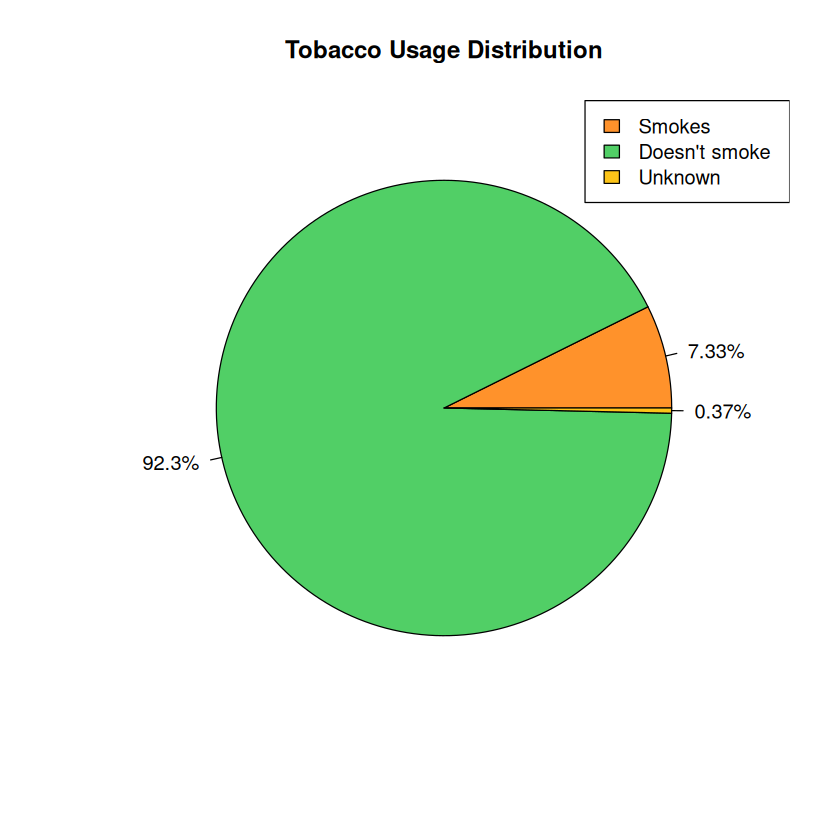

In [5]:
plot_pie_chart = function(x, col=1:length(x), legend=names(x), main="Pie Chart"){
    piepercent = paste(round(100*x/sum(x), 2), '%', sep="")
    
    pie(x, labels=piepercent, col=col, main=main)
    legend("topright", legend, fill=col)
}

plot_pie_chart(table(df$TOBACCO),
          col=c(col.orange, col.green, col.yellow),
          legend=c("Smokes", "Doesn't smoke", "Unknown"),
          main="Tobacco Usage Distribution"
         )

For other columns, like `PREGNANT`, the meaning of the numbers is not so clear.

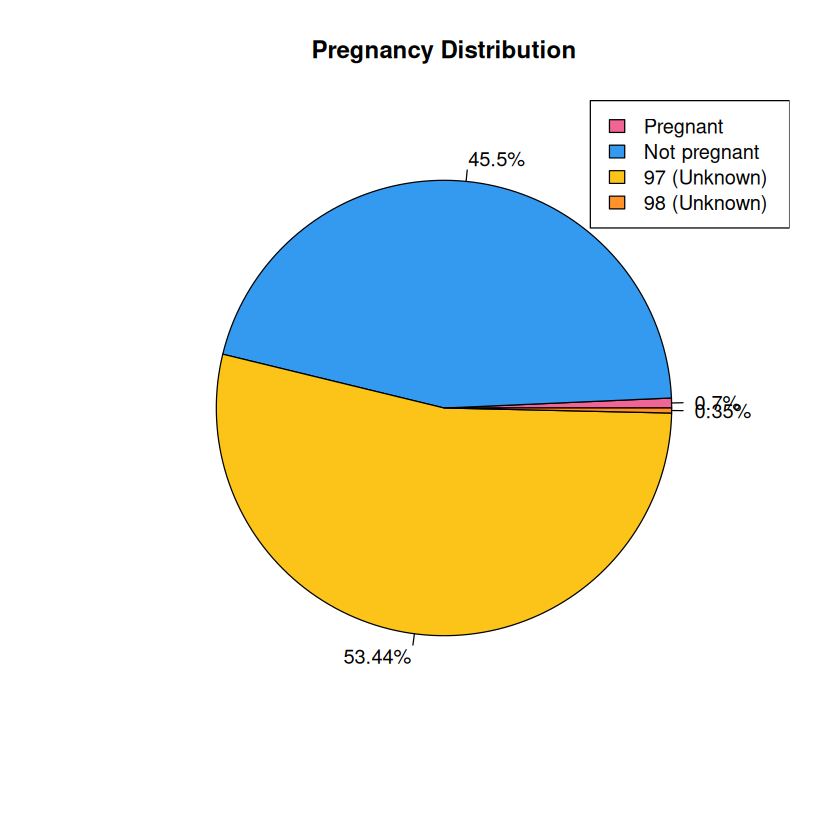

In [6]:
plot_pie_chart(table(df$PREGNANT),
          col=c(col.pink, col.blue, col.yellow, col.orange),
          legend=c("Pregnant", "Not pregnant", "97 (Unknown)", "98 (Unknown)"),
          main="Pregnancy Distribution"
         )

The amount of _97_ values is bigger than the number of non-pregnant patients. This could probably mean that _97_ was used as an indicator for values that do not make sense logically (for example, men cannot be pregnant).

We can check the amounts and see that they coincide:

In [7]:
print(paste("Number of male patients: ", table(df$SEX)[2]))
print(paste("Number of 97 values: ", table(df$PREGNANT)[3]))

[1] "Number of male patients:  209489"
[1] "Number of 97 values:  209489"


Let's start by removing rows which have missing values on each variable:

In [8]:
df = df[df$PNEUMONIA != 99,]
df = df[df$INTUBED != 99,]
df = df[df$ICU != 99,]
df = df[df$DIABETES != 98,]
df = df[df$COPD != 98,]
df = df[df$ASTHMA != 98,]
df = df[df$INMSUPR != 98,]
df = df[df$HIPERTENSION != 98,]
df = df[df$OTHER_DISEASE != 98,]
df = df[df$CARDIOVASCULAR != 98,]
df = df[df$OBESITY != 98,]
df = df[df$RENAL_CHRONIC != 98,]
df = df[df$TOBACCO != 98,]
df = df[df$PREGNANT != 98,]

row.n2 = nrow(df)
print(paste("Removed", row.n1 - row.n2, "rows."))
print(paste(row.n2, "rows left in dataframe."))

[1] "Removed 662475 rows."
[1] "386100 rows left in dataframe."


Now, replace the _97_ values in columns where it makes sense.

* Men cannot be pregnant;
* Non-hospitalized patients cannot be intubed;
* Non-hospitalized patients cannot be in intensive care.

We will also replace the _2_ values with _0_, because it better signifies the absence of a given trait.

In [9]:
# fix unknown values
df$PREGNANT[df$PREGNANT == 97] <- 0
df$INTUBED[df$INTUBED == 97] <- 0
df$ICU[df$ICU == 97] <- 0

# replace negative cases
df$USMER[df$USMER == 2] <- 0
df$SEX[df$SEX == 2] <- 0
df$INTUBED[df$INTUBED == 2] <- 0
df$PNEUMONIA[df$PNEUMONIA == 2] <- 0
df$PREGNANT[df$PREGNANT == 2] <- 0
df$DIABETES[df$DIABETES == 2] <- 0
df$COPD[df$COPD == 2] <- 0
df$ASTHMA[df$ASTHMA == 2] <- 0
df$INMSUPR[df$INMSUPR == 2] <- 0
df$HIPERTENSION[df$HIPERTENSION == 2] <- 0
df$OTHER_DISEASE[df$OTHER_DISEASE == 2] <- 0
df$CARDIOVASCULAR[df$CARDIOVASCULAR == 2] <- 0
df$OBESITY[df$OBESITY == 2] <- 0
df$TOBACCO[df$TOBACCO == 2] <- 0
df$ICU[df$ICU == 2] <- 0

df$PATIENT_TYPE = df$PATIENT_TYPE - 1
# for this last variable, we need 1 to become 0
# and 2 to become 1, so we can just subtract 1.

df$DATE_DIED <- ifelse(df$DATE_DIED == "9999-99-99", 0, 1)
# For our analysis, we don't care about the exact date
# of the death of our patients. We can make it so we
# have 1 if the patient died, and 0 otherwise.

Finally, we can craft our target column `AT_RISK`, which will summarize if the patient can be considered at risk or not.
In particular, the column has value 1 if the patient has either:
* Been hospitalized,
* Been in Intensive Care Unit,
* Been intubed,
* Died.

We can also remove all the columns with useless or redundant information.

In [10]:
df$AT_RISK = df$DATE_DIED + df$INTUBED + df$ICU + df$PATIENT_TYPE
df$AT_RISK <- ifelse(df$AT_RISK > 0, 1, 0)

df = within(df, rm('CLASIFFICATION_FINAL', 'INTUBED', 'ICU', 'DATE_DIED', 'PATIENT_TYPE', 'MEDICAL_UNIT', 'USMER'))
head(df)

,SEX,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,AT_RISK
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
1,1,1,65,0,0,0,0,0,1,0,0,0,2,0,1
3,0,0,55,0,1,0,0,0,0,0,0,0,2,0,1
5,0,0,68,0,1,0,0,0,1,0,0,0,2,0,1
6,1,1,40,0,0,0,0,0,0,0,0,0,2,0,1
7,1,0,64,0,0,0,0,0,0,0,0,0,2,0,0
8,1,1,64,0,1,0,0,1,1,0,0,0,1,0,0


## Step 2: Data Visualization
Now that we have a clean dataset, we can plot some of our data.

>Please be wary that from now on all visualizations are valid under the assumption that they have already been tested positive for COVID.

First of all, the target column, where we expect to see some class imbalance.

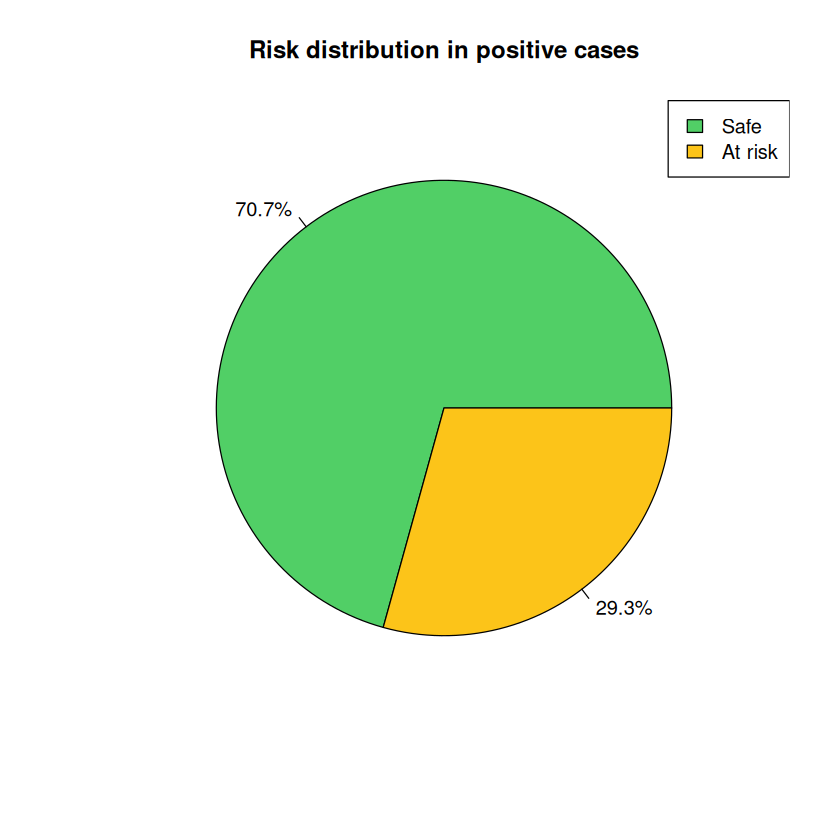

In [11]:
p = table(df$AT_RISK)
plot_pie_chart(p, col=c(col.green, col.yellow), legend=c("Safe", "At risk"), main="Risk distribution in positive cases")

The `AGE` column follows a _positively-skewed_ normal distribution:

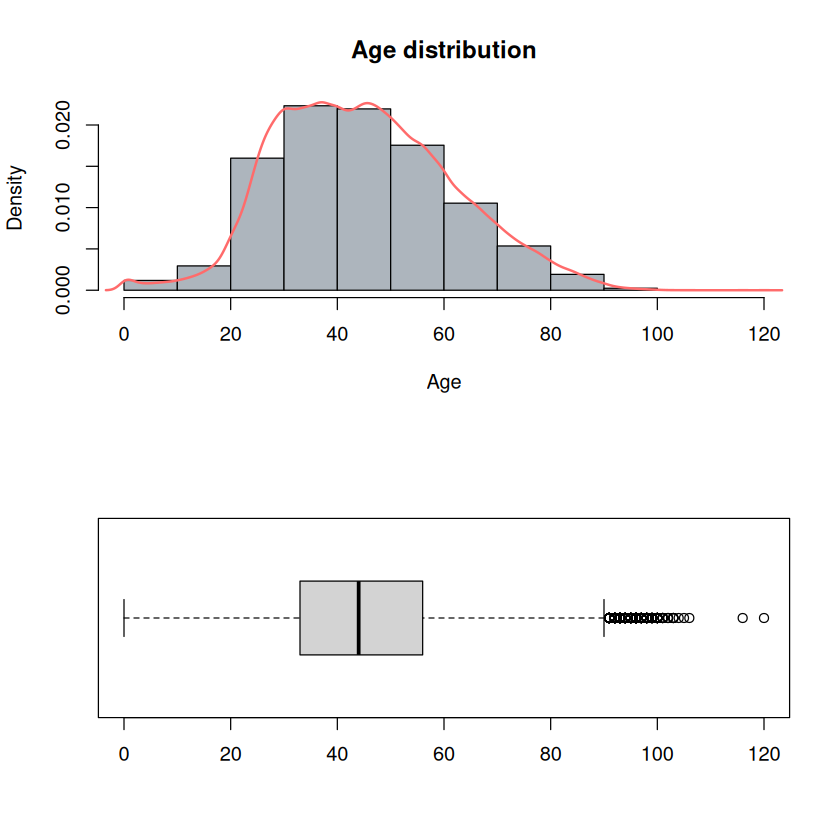

In [12]:
par(mfrow=c(2,1))
hist(df$AGE, freq=FALSE, col=col.gray, main="Age distribution", xlab="Age", breaks=10)
lines(density(df$AGE), col=col.red, lwd=2)
boxplot(df$AGE, horizontal=TRUE)

Let's check out more interesting pie graphs:

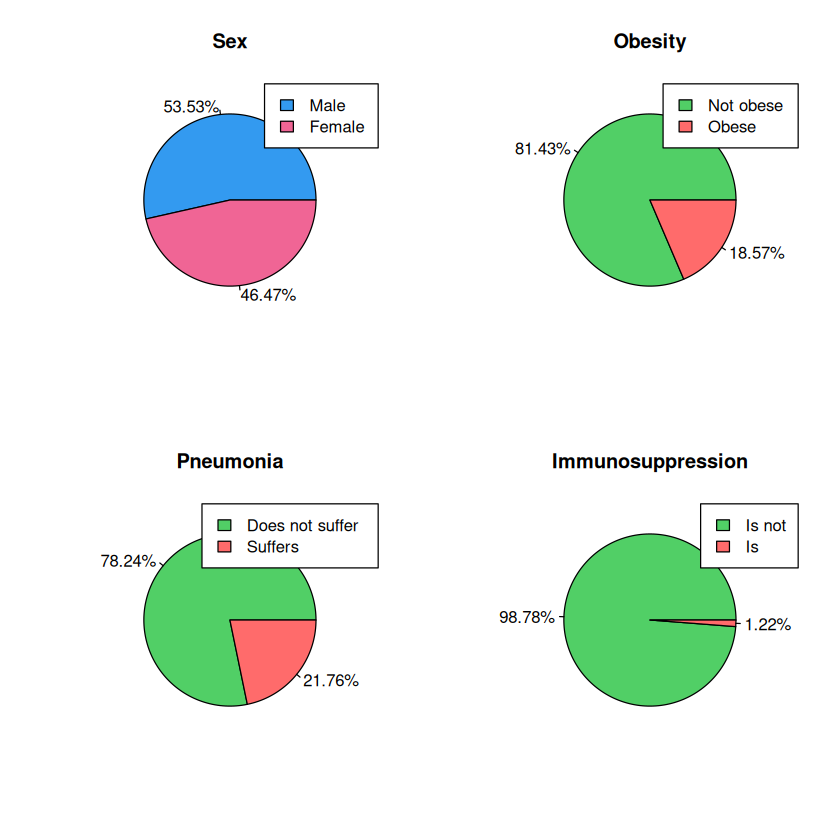

In [13]:
par(mfrow=c(2,2))

plot_pie_chart(table(df$SEX),
          col=c(col.blue, col.pink),
          legend=c("Male", "Female"),
          main="Sex"
         )
plot_pie_chart(table(df$OBESITY),
          col=c(col.green, col.red),
          legend=c("Not obese", "Obese"),
          main="Obesity"
         )
plot_pie_chart(table(df$PNEUMONIA),
          col=c(col.green, col.red),
          legend=c("Does not suffer", "Suffers"),
          main="Pneumonia"
         )
plot_pie_chart(table(df$INMSUPR),
          col=c(col.green, col.red),
          legend=c("Is not", "Is"),
          main="Immunosuppression"
         )

Let's now compute the covariance matrix. It is a symmetric matrix that contains the variance of each feature and the cross-features covariances:

$$
\Sigma =
\begin{bmatrix}
Var(x) & Cov(x, y) \\
Cov(y, x) & Var(y)
\end{bmatrix}
$$

When the two features are positively correlated, the covariance is greater than zero, otherwise, it has a negative value. Furthermore, if there is no evidence of a correlation between them, the covariance is equal to zero.

We'll use the `round()` function to get results up to the third decimal unit.

In [14]:
cov_matrix = cov(df)
round(cov_matrix, 3)

,SEX,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,AT_RISK
SEX,0.249,-0.019,-0.348,0.004,-0.001,0.000,0.004,0.001,0.001,0.002,-0.001,0.004,0.001,-0.013,-0.025
PNEUMONIA,-0.019,0.170,2.330,-0.001,0.034,0.004,-0.001,0.002,0.033,0.003,0.004,0.013,-0.005,0.002,0.129
AGE,-0.348,2.330,270.189,-0.116,1.984,0.311,-0.065,0.066,2.588,0.124,0.322,0.374,-0.215,0.001,3.202
PREGNANT,0.004,-0.001,-0.116,0.007,-0.001,0.000,0.000,0.000,-0.001,0.000,0.000,-0.001,0.000,0.000,0.000
DIABETES,-0.001,0.034,1.984,-0.001,0.133,0.004,0.000,0.002,0.054,0.002,0.005,0.015,-0.008,0.001,0.046
COPD,0.000,0.004,0.311,0.000,0.004,0.015,0.001,0.001,0.005,0.001,0.002,0.002,-0.001,0.002,0.006
ASTHMA,0.004,-0.001,-0.065,0.000,0.000,0.001,0.026,0.000,0.001,0.000,0.000,0.003,0.000,0.000,-0.001
INMSUPR,0.001,0.002,0.066,0.000,0.002,0.001,0.000,0.012,0.002,0.002,0.001,0.001,-0.002,0.000,0.003
HIPERTENSION,0.001,0.033,2.588,-0.001,0.054,0.005,0.001,0.002,0.157,0.003,0.009,0.023,-0.010,0.001,0.047
OTHER_DISEASE,0.002,0.003,0.124,0.000,0.002,0.001,0.000,0.002,0.003,0.025,0.001,0.001,-0.001,0.001,0.005


We can scan the `AT_RISK` row horizontally and find out that the highest values lie in the intersections with the `AGE` and `PNEUMONIA` columns.
Also, the `AGE` column has the highest value for variance, since it's the only numerical variable.

Let's now use the `corrplot` function as a way to visualize the correlation matrix.

We can use the `method` parameter of the `cor()` function to define which correlation coefficient (or covariance) should be computed. Some choices are:
* Pearson's product-moment correlation coefficient ($r$),
* Kendall's rank correlation coefficient ($\tau$),
* Spearman's rank correlation coefficient ($\rho$).

We can also use the `order` parameter of the `corrplot()` function to indicate how to reorder the correlation matrix, in particular:
* `AOE` for the angular order of the eigenvectors,
* `FPC` for the first principal component order,
* `hclust` for hierarchical clustering order,
* `alphabet` for alphabetical order.

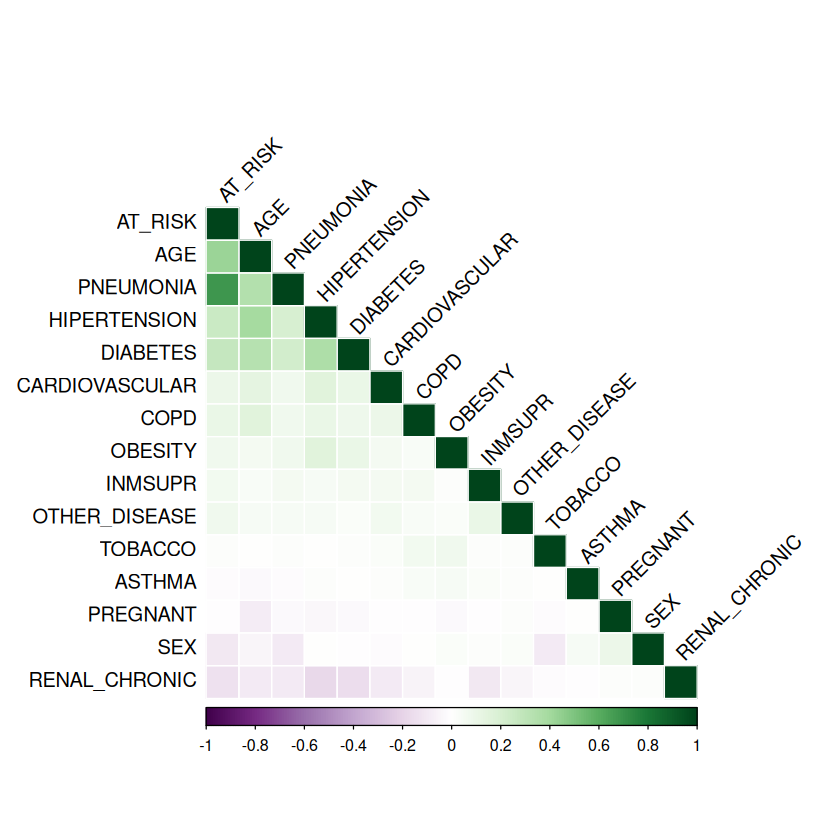

In [15]:
cor_matrix = cor(df,
    method="pearson" # {"pearson", "kendall", "spearman"}
)

corrplot(cor_matrix,
    type="lower",
    addgrid.col = 'white', # grid color
    method="color", # make only colored squares
    order="FPC", # {"AOE", "FPC", "hclust", "alphabet"}
    tl.srt=45, # text-label rotation
    tl.col="black", # text-label color
    col=COL2("PRGn") # color scheme
)

With this visualization, it's easy to distinguish some _positive correlations_ by looking at the first column:
* between `AT_RISK` and `PNEUMONIA`;
* between `AT_RISK` and `AGE`;
* in general, between `AGE` and various diseases.

## Step 3: Unsupervised Learning
### PCA
We can use the `prcomp()` function to perform principal component analysis. However, it quickly becomes very slow for datasets with a big number of rows.

To solve this, we can use the `sample()` function to take a random subset of 10.000 elements.

In [16]:
set.seed(2)
ss = sample(1:nrow(df), 10000) # take 10.000 random rows
df.subset = df[ss,] # select only those rows from our dataframe

Now we can use the `prcomp()` function to make our PCA.

In [17]:
pca = prcomp(df.subset, scale=TRUE)
names(pca)

[1] "sdev"     "rotation" "center"   "scale"    "x"

The `prcomp()` function returns the following outputs:
| Element | Description |
|:---|:-------------|
| sdev | the standard deviations of the PCs |
| rotation | the matrix of variable loadings |
| center | the variable means that were subtracted |
| scale | the variable standard deviations |
| x | the coordinates of each observation on the PCs. |

In [18]:
summary(pca)

Importance of components:
                          PC1     PC2    PC3     PC4     PC5     PC6     PC7
Standard deviation     1.6349 1.11449 1.0656 1.04143 1.01888 1.00499 0.98869
Proportion of Variance 0.1782 0.08281 0.0757 0.07231 0.06921 0.06733 0.06517
Cumulative Proportion  0.1782 0.26100 0.3367 0.40901 0.47822 0.54555 0.61072
                           PC8     PC9   PC10    PC11    PC12    PC13    PC14
Standard deviation     0.97680 0.95036 0.9287 0.90777 0.90483 0.80987 0.72783
Proportion of Variance 0.06361 0.06021 0.0575 0.05494 0.05458 0.04373 0.03532
Cumulative Proportion  0.67433 0.73454 0.7920 0.84697 0.90156 0.94528 0.98060
                         PC15
Standard deviation     0.5395
Proportion of Variance 0.0194
Cumulative Proportion  1.0000

We can quickly visualize the first two principal components by creating a biplot with this function:

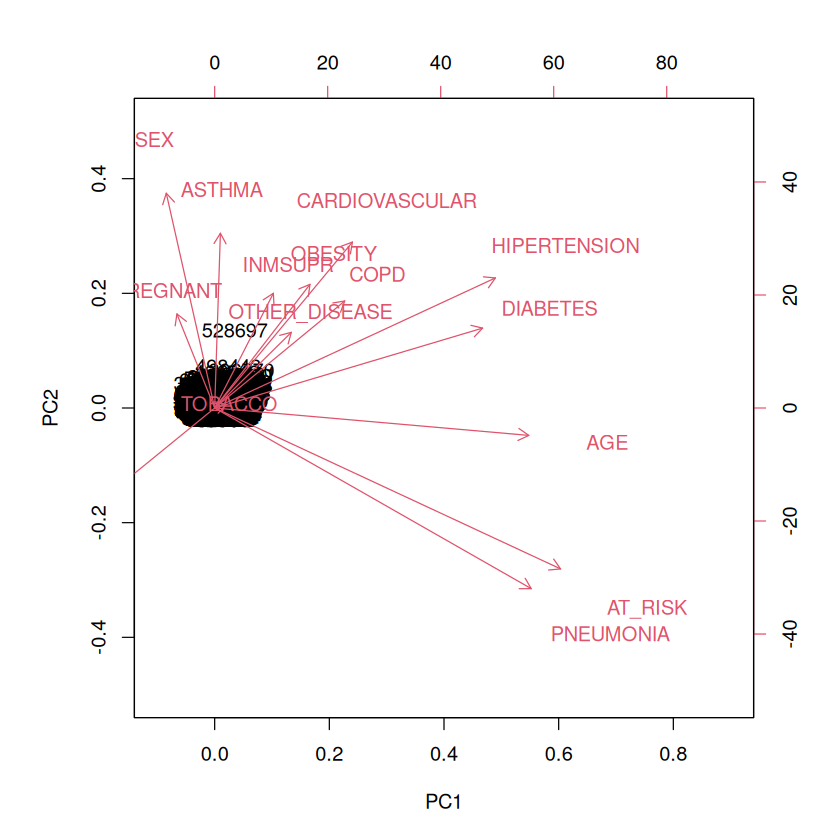

In [19]:
range = 1
x.start = -0.1
y.start = -0.5

biplot(pca,
       expand = 20, # zoom level
       xlim=c(x.start, (x.start + range)), # x axis limitations
       ylim=c(y.start, (y.start + range)) # y axis limitations
)

Keep in mind, I used the `expand` parameter to zoom in on the graph, so there are some samples that are not visible in this plot.

However, this graph makes it clear how the first PC is almost completely governed by `AGE`'s variability.

* As we move towards increasing `AGE`, we also see an increase for `AT_RISK`;
* The same goes for `PNEUMONIA`, in an even greater measure.

We can check out the `rotation` matrix to verify that PC1 has large coefficients for `AGE`, `PNEUMONIA` and `AT_RISK`.

These represent the variance of data along the PC axes.

In [20]:
pca$rotation

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15
SEX,-0.065475537,0.426351367,-0.37769519,0.26515956,0.232970839,0.045771961,0.25537192,-0.07484843,0.25368812,0.28213088,-0.43166984,-0.37556134,0.02969184,-0.022522082,-0.0325132403
PNEUMONIA,0.428334895,-0.358556764,-0.18793277,-0.10532340,0.245056054,0.083046629,-0.10778804,-0.03384113,-0.02082018,-0.02861701,-0.25594473,-0.04860265,0.09659994,-0.226054575,0.6574855652
AGE,0.425033270,-0.054395110,0.01434897,0.15953241,-0.006506965,-0.038902290,0.18497774,-0.14918872,0.10210436,0.03191891,0.20655457,-0.12131873,-0.43583162,0.676816393,0.1258764020
PREGNANT,-0.051110559,0.186686556,-0.37278634,0.03756730,0.555519688,-0.253599105,-0.24087832,0.47312294,-0.06022703,-0.12269556,0.33567339,0.14614751,-0.06511354,0.099560404,0.0224344573
DIABETES,0.362534735,0.158596021,0.03918978,0.23971147,-0.153345180,0.063341488,-0.02211305,0.09281797,0.09558067,0.16748692,0.33957599,-0.02232894,0.76252238,0.114085598,0.0182626960
COPD,0.175990849,0.212420213,0.20531228,-0.16668667,0.210932029,-0.485640115,0.23008251,-0.29620791,0.36513186,-0.09699256,-0.13002564,0.50895217,0.09812794,-0.068034791,-0.0050919606
ASTHMA,0.007739916,0.346889205,0.03590655,-0.06935040,0.249092737,0.327722314,-0.51349661,-0.60904742,-0.15962579,0.11776153,0.14026481,0.08747732,-0.04383208,0.027160831,0.0104377177
INMSUPR,0.079436163,0.227740047,-0.28081368,-0.51229741,-0.266071477,0.211081752,-0.07838967,0.03604258,0.47471202,-0.44255296,0.13082010,-0.19797585,-0.01356665,-0.001766035,0.0050730204
HIPERTENSION,0.379829904,0.258177587,0.10057429,0.27295676,-0.161291637,0.001906995,0.02437790,0.10800334,0.04105158,0.07336555,0.27859000,-0.01799374,-0.42081750,-0.635599936,-0.0098396727
OTHER_DISEASE,0.103721651,0.150202420,-0.24975286,-0.50869242,-0.030664995,0.179582884,0.48219338,0.05196526,-0.39084899,0.38990562,0.14580216,0.22507650,-0.01452712,-0.012542088,0.0077473695


As we said before, `pca$sdev` is a vector containing the _standard deviations_ $\sigma$ of the PCs. We can square it to get their _variances_ $\sigma^2$ or _eigenvalues_.

Of course, the sum of all variances should be equal to the number of PCs.

Furthermore, according to the _Kaiser criterion_, we should only choose PCs that have $\sigma^2>1$.

In [21]:
variance = pca$sdev^2

round(variance, 3)
n.pcs = length(variance)
print(paste("There are", n.pcs, "PCs. The sum of their variance is", round(sum(variance))))
print(paste("The first", length(variance[variance>1]), "PCs satisfy Kaiser's rule."))

[1] 2.673 1.242 1.136 1.085 1.038 1.010 0.978 0.954 0.903 0.863 0.824 0.819
[13] 0.656 0.530 0.291

[1] "There are 15 PCs. The sum of their variance is 15"
[1] "The first 6 PCs satisfy Kaiser's rule."


It's now possible to find out the total variance explained by each PC. Let's plot it.

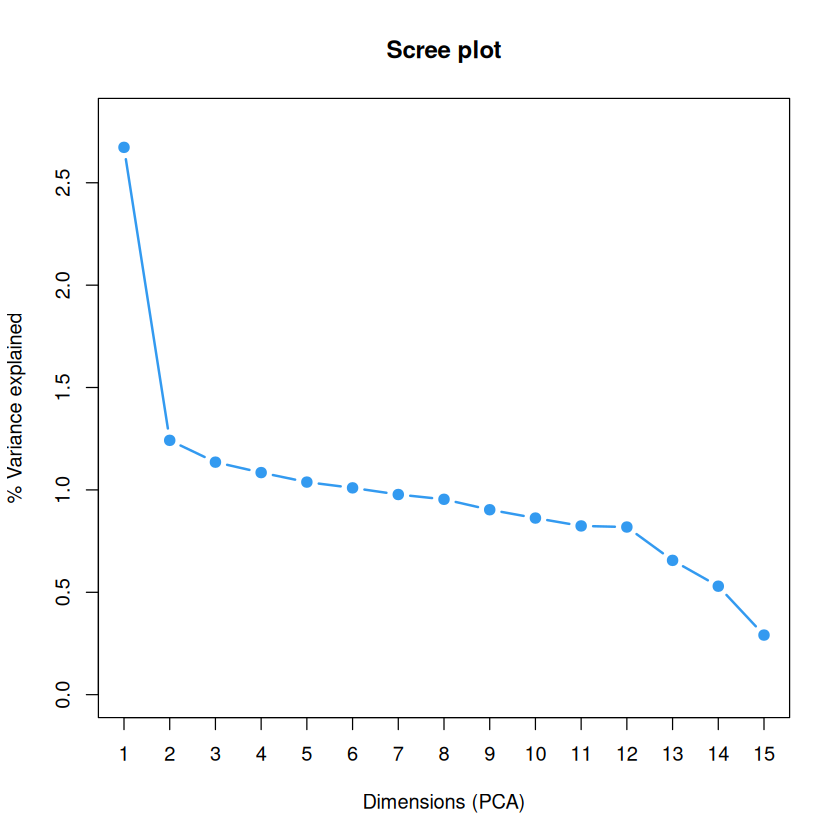

In [22]:
plot(variance,
    main = "Scree plot",
    xlab = "Dimensions (PCA)", # x axis label
    ylab = "% Variance explained", # y axis label
    ylim = c(0,2.8), # get a clearer y axis
    xaxt = 'n', # don't draw the x axis (yet)
    type = "b", # draw both points and line
    col = col.blue, # graph color
    pch = 19, # point symbol (19: filled circle)
    lwd = 2, # line width
)
axis(1,at=seq(1:n.pcs)) # draw an x axis with all values

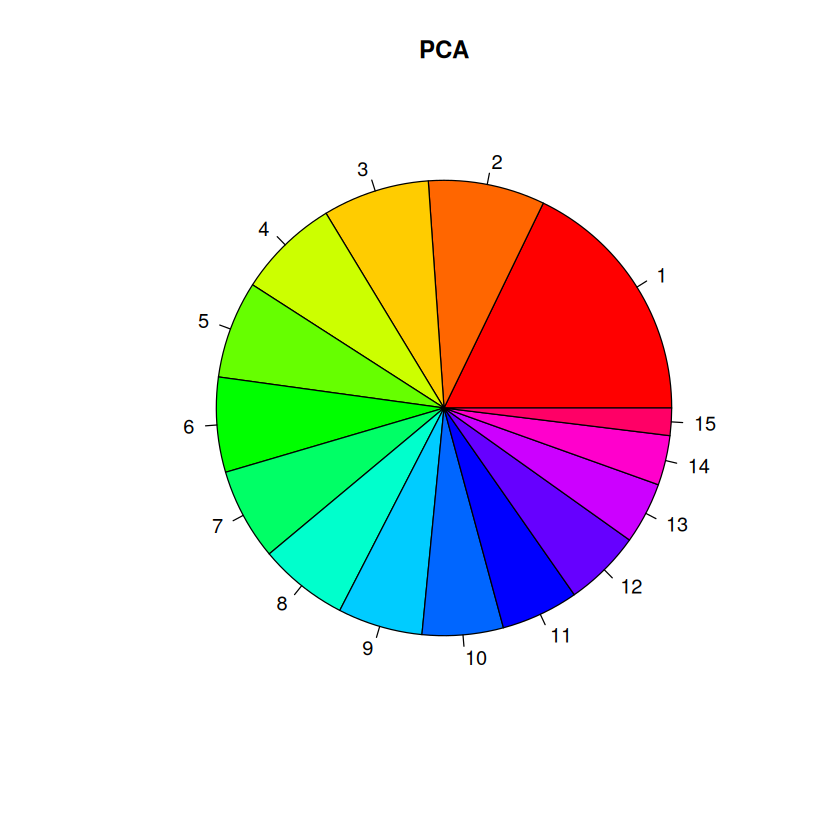

In [23]:
pie(variance, main="PCA", col=rainbow(n.pcs))

For visual clarity, let's choose just the first 4 PCs and plot the observations.

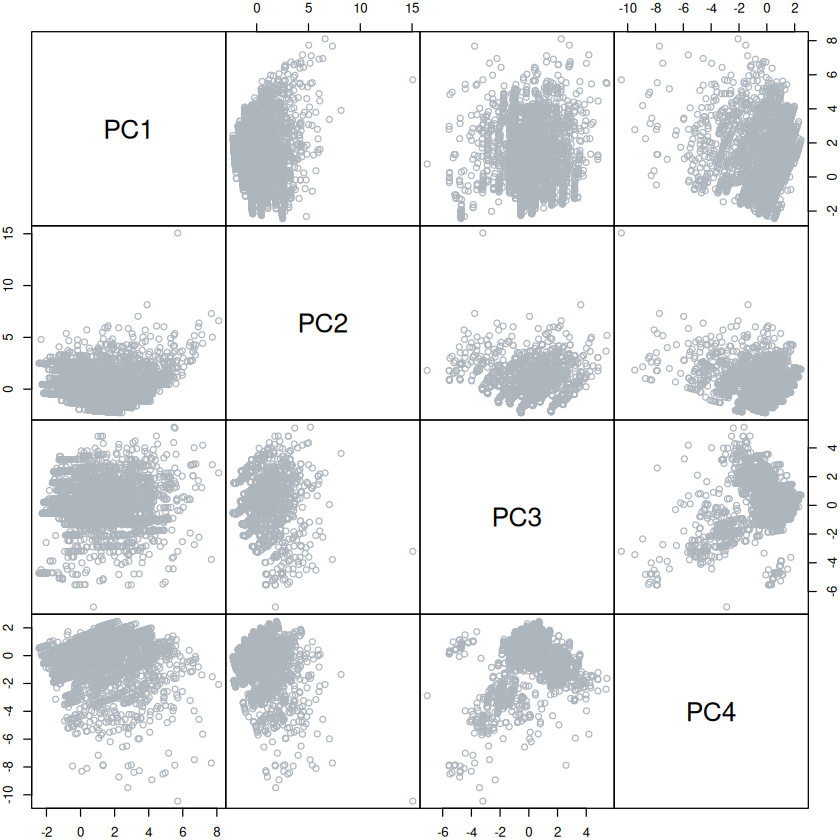

In [24]:
pca.four = pca$x[,1:4] # select only the first 4 columns

pairs(pca.four,
      gap = 0, # inner gaps
      oma = c(2,2,2,2), # outer margins
      col = col.gray
)

### Clustering
Clustering's task is to divide the population or data points into a number of groups, such that data points in a group are more similar to other data points in the same group and dissimilar to the data points in other groups.

If we were working with continuous data, we could use the _k-means_ algorithm, as it's based on mathematical measures of distance. But our dataset is mostly comprised of categorical data points.

Luckily, we can use _k-modes_, which uses dissimilarities between the data points and it's based on modes instead of means. The only problem we need to solve is that the `AGE` column is not categorical.

However, we can use the `CUT` function to break it into bins of 10 years.

In [25]:
df.cat = df.subset
df.cat$AGE_GROUP <- cut(df.cat$AGE,
                        breaks = c( # bounds for each bin
                                    seq(0, 100, by = 10), # generates an array of multiples of 10
                                    Inf # the last bound is infinity
                        ),
                        labels = c(1:11), # we could name the bins but it's better to enumerate them
                        right = FALSE # should the intervals be closed on the right (and open on the left)?
)
head(df.cat)

,SEX,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,AT_RISK,AGE_GROUP
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<fct>
580566,1,1,43,0,0,0,0,0,0,1,0,0,2,0,1,5
611491,1,0,17,0,0,0,0,0,0,0,0,0,2,0,0,2
78430,1,0,28,0,0,0,0,0,0,0,0,0,2,0,0,3
59825,1,0,48,0,0,0,0,0,0,0,0,0,2,0,0,5
549817,1,0,65,0,0,0,0,0,1,0,0,0,2,0,0,7
101223,0,0,46,0,0,0,0,0,0,0,0,0,2,0,0,5


At this point, we can remove the `AGE` column.

In [26]:
df.cat = within(df.cat, rm('AGE'))
table(df.cat$AGE_GROUP)


   1    2    3    4    5    6    7    8    9   10   11 
  90  217 1408 2299 2196 1832 1090  626  216   25    1 

Now we can finally start fitting the _k-modes_ clustering algorithm with $k=4$.

As soon as it's done, we add the cluster column to our subset and check that everything went alright.

In [27]:
k = 2
fit = kmodes(df.cat, k)
df.clustered = data.frame(CLUSTER=fit$cluster, df.cat)
head(df.clustered, 10)

,CLUSTER,SEX,PNEUMONIA,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,AT_RISK,AGE_GROUP
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<fct>
580566,2,1,1,0,0,0,0,0,0,1,0,0,2,0,1,5
611491,1,1,0,0,0,0,0,0,0,0,0,0,2,0,0,2
78430,1,1,0,0,0,0,0,0,0,0,0,0,2,0,0,3
59825,1,1,0,0,0,0,0,0,0,0,0,0,2,0,0,5
549817,1,1,0,0,0,0,0,0,1,0,0,0,2,0,0,7
101223,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,5
79748,1,1,1,0,0,0,0,0,0,0,0,0,2,0,0,3
615331,1,1,0,0,0,0,0,0,0,0,0,0,2,0,0,6
384204,2,0,0,0,0,0,0,0,0,0,0,0,2,0,1,5


We can use the `clusplot` function from the `cluster` library to easily visualize clusters:

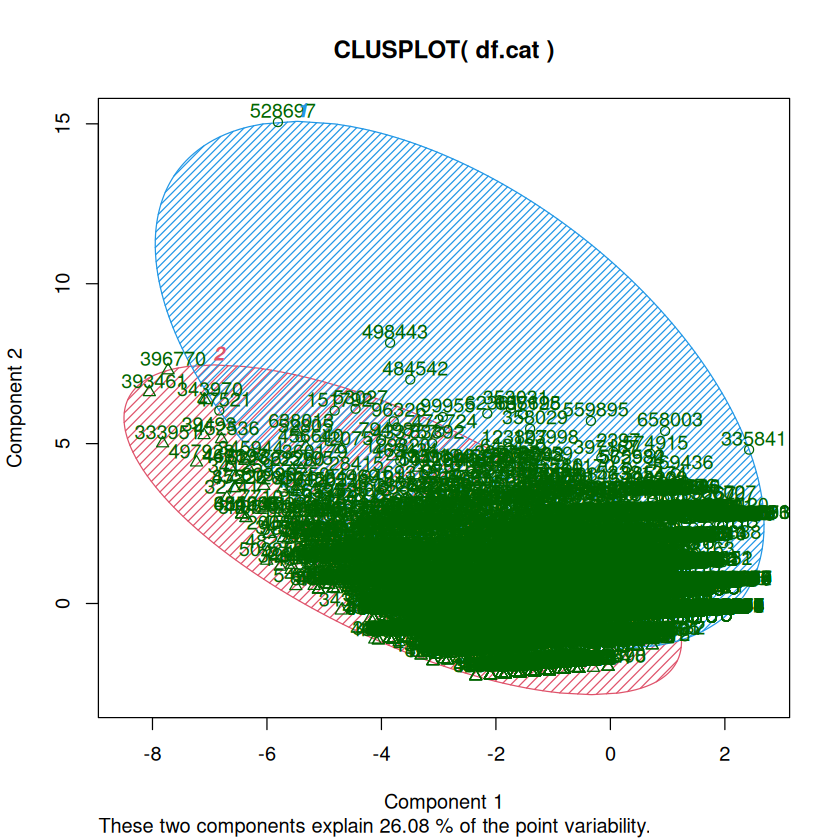

In [28]:
clusplot(df.cat, fit$cluster, color=TRUE, shade=TRUE, labels=2, lines=0)

It's clear that, even with the _k-modes_ approach, this dataset does not perform well in regards to cluster analysis.

## Step 4: Supervised Learning
### Logistic Regression
Now, let's try to predict whether a patient who tested positive for COVID is actually at risk; this is a classification task.

In particular, in our situation we only need to distinguish between two possible outcomes. Given some variables, we want to predict the _probability_ that a particular observation belongs to one class. This scenario is called _Binary Classification_.

The first thing one would think about is using linear regression, but remember: our $y$ variable is a categorical value. This is a problem, because linear regression will just fit a line and produce estimates $\hat{y}$ that fall outside the range $[0, 1]$.

However, there is a solution. Rather than modeling _y_ directly, _Logistic Regression_ models the _probability_ that _y_ belongs to a particular category given some _X_ variable(s), for example:

$$
P(\text{AT_RISK}=\text{Yes}|\text{PNEUMONIA})
$$

The output of a logistic regression model will be values between $[0,1]$, which we can convert to class labels using a decision threshold.

First of all, we need to split our dataset in two horizontally. The larger set will be used for training our model, while the smaller one is useful for evaluating its performance.

In [29]:
set.seed(2)
train.percent = 0.8

df$AT_RISK = as.factor(df$AT_RISK)
s = sample(c(TRUE, FALSE), nrow(df), replace=TRUE, prob=c(train.percent, (1 - train.percent)))

train = df[s,]
test = df[!s,]

Next, we should separate the dependent variable $y$ from the independent variables $X$.

In [30]:
X_train = train[,1:(length(train)-1)]
y_train = train$AT_RISK

X_test = test[,1:(length(test)-1)]
y_test = test$AT_RISK

Finally it's time to fit our model. We can use the `glm` function, which is used to fit generalized linear models. We specify that we want to use the `binomial()` family, which uses the _logit_ (_sigmoid_) link function.
![sigmoid graph](res/sigmoid.png)

In [31]:
logistic_model = glm( # generalized linear model
                    formula=y_train~., # y=AT_RISK, X=. (all other columns)
                    data=X_train, # actual data values
                    family=binomial() # {"binomial", "gaussian", "Gamma", "inverse.gaussian",
)                                     #  "poisson", "quasi", "quasibinomial", "quasipoisson"}

saveRDS(logistic_model, file="model.rda") # export model to file
summary(logistic_model)


Call:
glm(formula = y_train ~ ., family = binomial(), data = X_train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.5690  -0.4856  -0.3336   0.2712   3.1002  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)    -1.9615652  0.0793765 -24.712  < 2e-16 ***
SEX            -0.4799111  0.0120138 -39.947  < 2e-16 ***
PNEUMONIA       3.7351540  0.0146266 255.368  < 2e-16 ***
AGE             0.0478965  0.0004166 114.969  < 2e-16 ***
PREGNANT        1.6461797  0.0594691  27.681  < 2e-16 ***
DIABETES        0.5910326  0.0154400  38.279  < 2e-16 ***
COPD            0.4011124  0.0430199   9.324  < 2e-16 ***
ASTHMA         -0.1473584  0.0378735  -3.891 9.99e-05 ***
INMSUPR         0.6642928  0.0482274  13.774  < 2e-16 ***
HIPERTENSION    0.2566937  0.0150923  17.008  < 2e-16 ***
OTHER_DISEASE   0.8016977  0.0328350  24.416  < 2e-16 ***
CARDIOVASCULAR  0.0979876  0.0367507   2.666  0.00767 ** 
OBESITY         0.1459514  0.0146886   9.936  

The `(Intercept)` value is the logarithm of the probability (_log-odds_) of the patient being at risk, given that all other variables are equal to $0$.

All other values under the column `Estimate` are the weights of a positive value on that column in regards to the patient being at risk.

We can also use the `cdplot` function to display the conditional density plot of a binary outcome on the continuous $x$ variable. Since the only numerical variable we have is `AGE`, we can try that one.

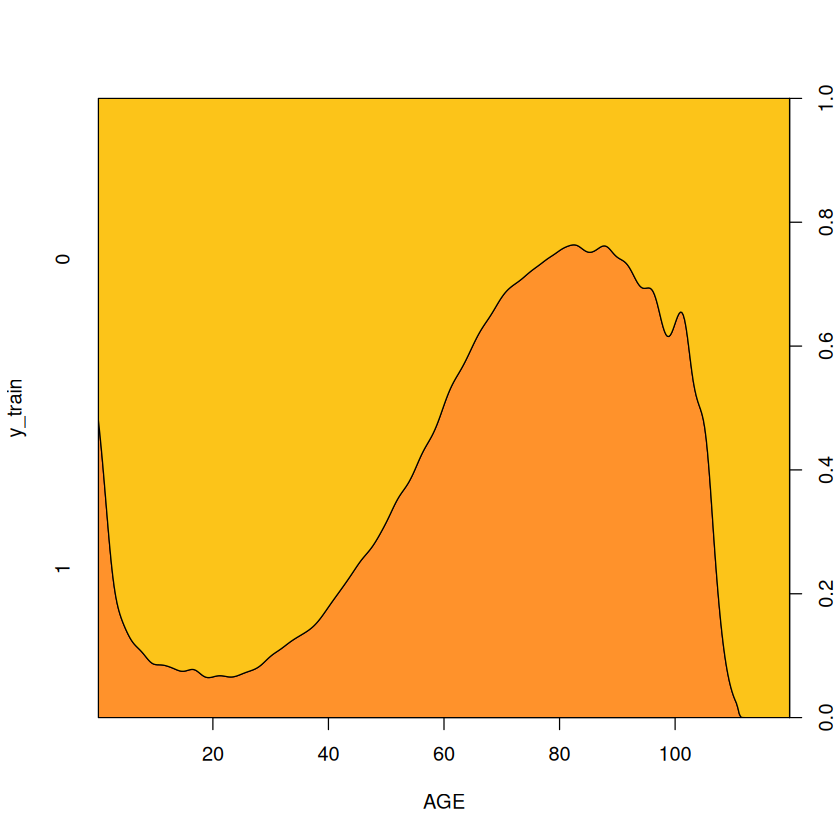

In [32]:
cdplot(y_train~AGE, data=X_train, col=c(col.orange, col.yellow))

Using the `predict` function, we can output our logistic regression model’s _predictions_. By default, this will output the _log-odds_. However, we can use the `type='response'` parameter to force this function to output probabilities of the form $P(y=1|X)$.

Let's predict some probabilities based on our test dataset.

In [33]:
predictions = predict(logistic_model, X_test, type="response")
head(round(predictions, 3))

7     8    10    18    19    25 
0.166 0.991 0.030 0.218 0.166 0.149

As you can see, these are all numbers in the interval $[0,1]$. But we want classes, not probabilities!

Let's just apply a threshold of $0,5$. If the probability is above the threshold's value, the patient is considered at risk.

In [34]:
get_classes = function(predictions, threshold=0.5)
    return(ifelse(predictions > threshold, 1, 0))

predicted_classes = get_classes(predictions)

tail(data.frame(probability=predictions, predicted=predicted_classes, actual=y_test), 6)

,probability,predicted,actual
,<dbl>,<dbl>,<fct>
1047914,0.26430374,0,1
1047918,0.68294292,1,0
1047926,0.15928020,0,0
1047928,0.36330969,0,0
1047930,0.52057782,1,1
1047931,0.03587678,0,0


### Model Evaluation
In the table above you can see a case where the model predicted a patient was not at risk when in actuality they were. In medical cases, this does not have the same importance as the case below, where we predicted a patient was at risk while they were not.

In some cases, _false negatives_ are way more important than _false positives_. We need a way to highlight this discrepancy, so let's introduce some metrics.

* _Accuracy_ is the proportion of true results among the total number of cases examined.
* _Precision_ is the proportion of predicted positives that are actual positives.
* _Recall_ is the proportion of actual positives that were correctly predicted.
* _$F_1$ score_ is the harmonic mean of precision and recall.

Let $TP$ be the number of true positives, $FP$ the number of false positives, $TN$ the true negatives and $FN$ the false negatives, here's how you find these measures:

$$
\text{Accuracy} = \frac{TP+TN}{TP+FP+FN+TN};
\quad
\text{Precision} = \frac{TP}{TP+FP};
\quad
\text{Recall} = \frac{TP}{TP+FN};
\quad
F_1 = 2 * \frac{\text{Precision} * \text{Recall}}{\text{Precision} + \text{Recall}}
$$

If we want to minimize the number of false negatives (even at the cost of increasing false positives), we want to maximize the _Recall_ metric!

Let's start by computing all of these statistics for our model. First, we build a so-called _confusion matrix_. Then, we can find out all of the other metrics.

In [35]:
create_confusion_matrix = function(actual, predicted){
    confusion.matrix = table(Actual=actual, Predicted=predicted)

    tp = confusion.matrix[2,2]
    tn = confusion.matrix[1,1]
    fp = confusion.matrix[1,2]
    fn = confusion.matrix[2,1]

    #accuracy = (tp + tn) / (tp + fp + fn + tn)
    accuracy = mean(predicted_classes == y_test)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)

    print(paste("Accuracy:", accuracy))
    print(paste("Precision:", precision))
    print(paste("Recall:", recall))
    print(paste("F1:", f1))

    return(confusion.matrix)
}

(c.m = create_confusion_matrix(y_test, predicted_classes))

[1] "Accuracy: 0.877407717580365"
[1] "Precision: 0.864284525328747"
[1] "Recall: 0.687847743530866"
[1] "F1: 0.766038014212299"


      Predicted
Actual     0     1
     0 52523  2446
     1  7069 15577

We can use the `corrplot` function we used before to plot our confusion matrix.

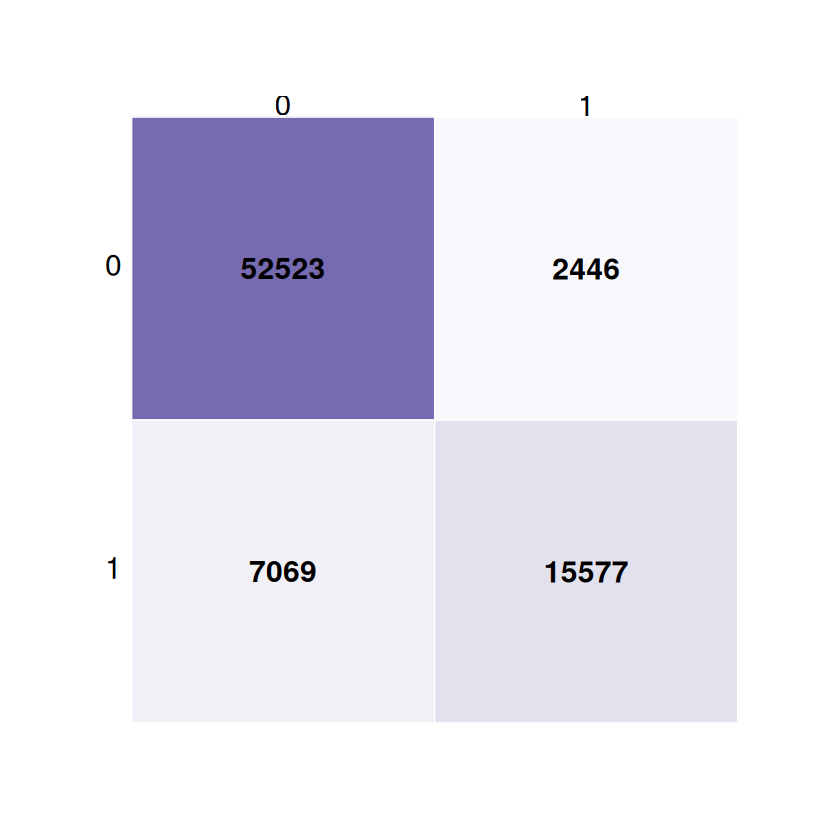

In [36]:
plot_confusion_matrix = function(x){
    corrplot(x,
        method = "color", # make only colored squares
        mar = c(4, 4, 4, 4), # set margins
        is.corr = FALSE, # not a correlation matrix
        addgrid.col = 'white', # add a grid
        addCoef.col = 'black', # coefficient text color
        number.cex = 1.5, # coefficient text size
        col = COL1("Purples"), # color scheme
        col.lim = c(0, sum(x)), # scale color correctly
        cl.pos = "n", # remove color legend
        tl.srt = 0, # text-label rotation
        tl.col = "black", # text-label color
        tl.cex = 1.5 # text-label size
    )
}

plot_confusion_matrix(c.m)

Although an accuracy of $87\%$ looks good on paper, our model produces a lot of false negatives. This is unacceptable.

We can change how it behaves by setting a different threshold. For example, let's set it to $0,25$.

In [37]:
predicted_classes = get_classes(predictions, threshold=0.25)

(c.m = create_confusion_matrix(y_test, predicted_classes))

[1] "Accuracy: 0.857540423887135"
[1] "Precision: 0.739116081376635"
[1] "Recall: 0.790912302393359"
[1] "F1: 0.764137460270057"


      Predicted
Actual     0     1
     0 48647  6322
     1  4735 17911

As you can see, we now have a worse model in terms of accuracy, precision and F1 score. But that's what we want!

Now our predictions are less optimistic. We reduced the number of false negatives by increasing the number of false positives.
Let's plot our confusion matrix so that the difference is even more clear.

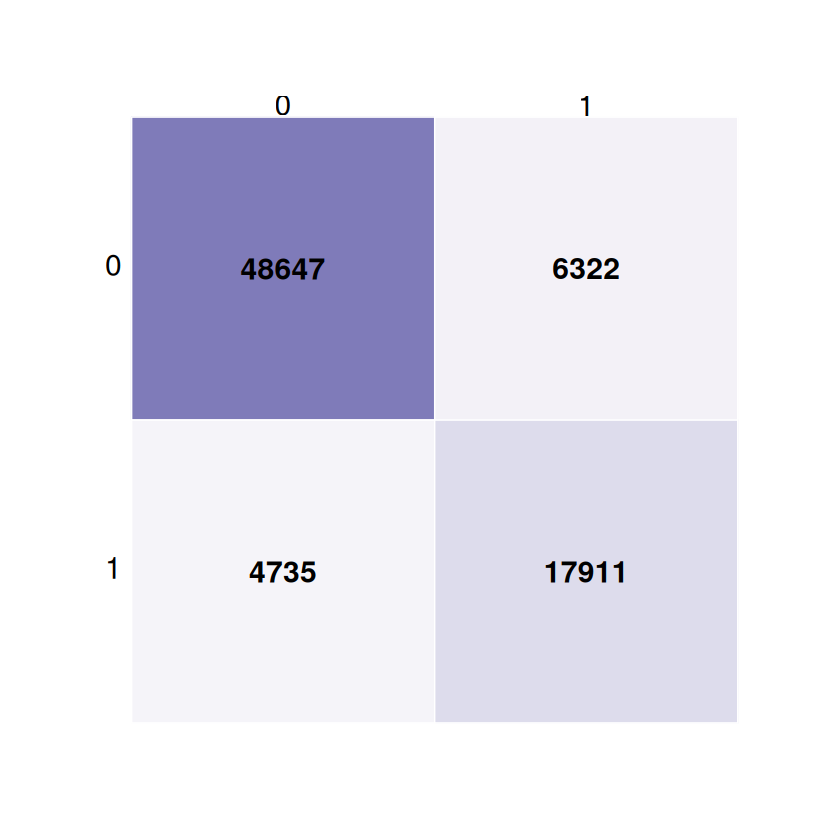

In [38]:
plot_confusion_matrix(c.m)